<a href="https://colab.research.google.com/github/salman-aziz-4425/Polarization-Analysis/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
from textblob import TextBlob
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install tensorflow
!pip install transformers
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import numpy
!pip install emoji
import emoji
import string,time
string.punctuation
import networkx as nx

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Fetching**

In [ ]:
df = pd.read_csv('/content/hateSpeech.csv')
df=pd.DataFrame(df)
print(df)

NameError: ignored

**Test Preprocessing**

In [ ]:
df=df.drop_duplicates(subset=['Tweets'])
print(df['Tweets'])

0      Black face of hypocrites. #PMLN political vult...
1      Latest opinion poll says every two out of thre...
2      https://t.co/FYKRu60tpD PM Imran Khan, who fac...
3      PTI still have the option of resigning from th...
4      The LORD JESUS ​​died and rose the third day f...
                             ...                        
995    Yesterday #BabarAzam𓃵 saved the #Pakistan from...
996    #Pakistan: The news of assassination plot come...
997    #ImranKhanPrimeMinister Ali Gillani from #UAE ...
998    Pakistan Prime Minister Imran Khan has been hy...
999    Breaking: Prime Minister of Pakistan @PakPMO r...
Name: Tweets, Length: 995, dtype: object


**Lower Case Text**

In [ ]:
df['Tweet'] = df['Tweets'].str.lower()
print(df['Tweet'].head(100))

0     black face of hypocrites. #pmln political vult...
1     latest opinion poll says every two out of thre...
2     https://t.co/fykru60tpd pm imran khan, who fac...
3     pti still have the option of resigning from th...
4     the lord jesus ​​died and rose the third day f...
                            ...                        
95    @michaelkugelman china would receive an additi...
96    breaking: shah mehmood qureshi had approached ...
97    this statement of @bbhuttozardari is from 2019...
98    mohtarma @maryamnsharif asks from where did @f...
99    maryam nawaz claims the threat letter from uni...
Name: Tweet, Length: 100, dtype: object


**Removing URLS**

In [ ]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)
df['Tweet']=df['Tweet'].apply(remove_url)
df=df.dropna()
print(df['Tweet'].head(100))

0     black face of hypocrites. #pmln political vult...
1     latest opinion poll says every two out of thre...
2      pm imran khan, who faces the prospect of bein...
3     pti still have the option of resigning from th...
4     the lord jesus ​​died and rose the third day f...
                            ...                        
95    @michaelkugelman china would receive an additi...
96    breaking: shah mehmood qureshi had approached ...
97    this statement of @bbhuttozardari is from 2019...
98    mohtarma @maryamnsharif asks from where did @f...
99    maryam nawaz claims the threat letter from uni...
Name: Tweet, Length: 100, dtype: object


**Handling Emojies,Short Words and Punctuation**

In [ ]:
df['Tweet']=df['Tweet'].apply(lambda x : emoji.demojize(x))
exclude = string.punctuation
def remove_punc1(text):
    return text.translate(str.maketrans('', '', exclude))

df['Tweet']=df['Tweet'].apply(lambda x : remove_punc1(x))

chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

chat_words_list = []
chat_words_map_dict = {}
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)
def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

df['Tweet']=df['Tweet'].apply(lambda x : chat_words_conversion(x))


**Remove Emoticons**

In [ ]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
     u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

remove_emoticons("Hello :-)")

def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

text = "Hello :-) :-)"
df['Tweet']=df['Tweet'].apply(lambda x:convert_emoticons(x))

Integrating Model

In [ ]:
tweets=list(df["Tweet"])
response=[]
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
for tweeter in tweets:
    text = preprocess(tweeter)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[2]:
      response.append("NEGATIVE")
    else:
      response.append("POSITIVE")

print(response)
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'PO

Saving Model DataSet

In [ ]:
df["Opinion"]=response
df.to_csv('/newOpinion.csv')
print(df)

ValueError: ignored

**Analysis**

In [ ]:
df=pd.read_csv('/newHateSpeech.csv')
df=pd.DataFrame(df)
Anchors=df['DisplayName']
Positive=[]
Negative=[]
Neutral=[]
for i in list(Anchors.drop_duplicates()):
  print(i)
  (row1,col1)=df[(df.DisplayName==i)&(df.Polarity=='positive')].shape
  (row2,col2)=df[(df.DisplayName==i)&(df.Polarity=='negative')].shape
  (row3,col3)=df[(df.DisplayName==i)&(df.Polarity=='neutral')].shape
  Positive.append(row1)
  Negative.append(row2)
  Neutral.append(row3)

print(Positive)


Kamran Khan
Hamid Mir
Najam Sethi
Wajahat S. Khan
Maria Memon
Moeed Pirzada
[256, 230, 265, 229, 424, 162]


**Individual Polarity of anchors**

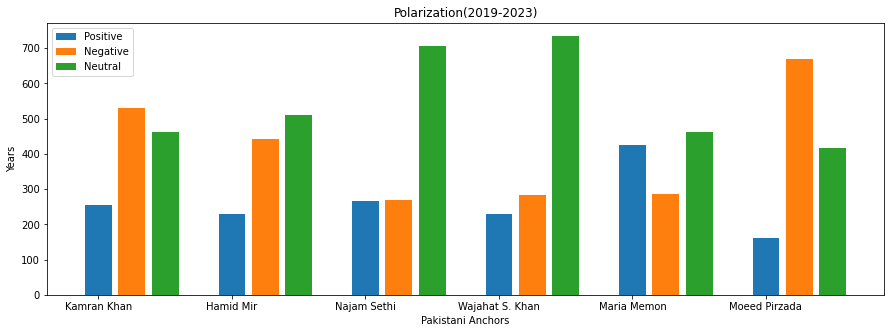

In [ ]:

X_axis = np.arange(len(list(Anchors.drop_duplicates())))
plt.subplots(figsize=(15,5))
width = 0.25
plt.bar(X_axis,Positive, 0.2, label = 'Positive')
plt.bar(X_axis+width,Negative, 0.2, label = 'Negative')
plt.bar(X_axis+ width*2,Neutral, 0.2, label = 'Neutral')
X = list(Anchors.drop_duplicates())
plt.xticks(X_axis, X)
plt.xlabel("Pakistani Anchors")
plt.ylabel("Years")
plt.title("Polarization(2019-2023)")
plt.legend()
plt.show()

Total Positive Negative Neutral

In [ ]:
df=pd.read_csv('/newHateSpeech.csv')
df=pd.DataFrame(df)
Anchors=df['DisplayName']
Allresponse=[]
(row1,col1)=df[(df.Polarity=='positive')].shape
(row2,col2)=df[(df.Polarity=='negative')].shape
(row3,col3)=df[(df.Polarity=='neutral')].shape
Allresponse.append(row1)
Allresponse.append(row2)
Allresponse.append(row3)

**PieChart of Total Polarity**

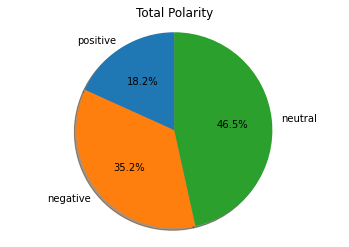

In [ ]:
y = np.array(Allresponse)
mylabels = ["positive", "negative", "neutral"]
plt.pie(y, labels = mylabels,startangle=90, shadow=True,autopct='%1.1f%%')
plt.title('Total Polarity')
plt.axis('equal')
plt.show()

**IMRAN KHAN**

In [ ]:
df=pd.read_csv('/newOpinion.csv')
df=pd.DataFrame(df)
df["Politician"]="IMRAN KHAN"
keywords = ["imran khan","pti","fuel prices"]
matches = df.loc[df.Tweet.apply(lambda x: any(k for k in keywords if k in x))][['Users','Tweet',"Opinion","Politician","Hastags"]]
againstImranKhan=matches[matches.Opinion=="NEGATIVE"]
withImranKhan=matches[matches.Opinion=="POSITIVE"]
print(len(againstImranKhan))
# create object
G=nx.DiGraph()

#set layout
pos=nx.spring_layout(G)

df["Politician"]="IMRAN KHAN"
againstImranKhan
subset = againstImranKhan[['Users',"Politician"]]
tuples = [tuple(x) for x in subset.values]
G.add_edges_from(tuples)

print(G)
# illustrate graph
#Perform Graph Drawing
#A star network  (sort of)
plt.subplots(figsize=(25,20))
nx.draw_networkx(G,font_color="red")
plt.title("Against Imran Khan")
plt.show()

FileNotFoundError: ignored

DiGraph with 301 nodes and 300 edges


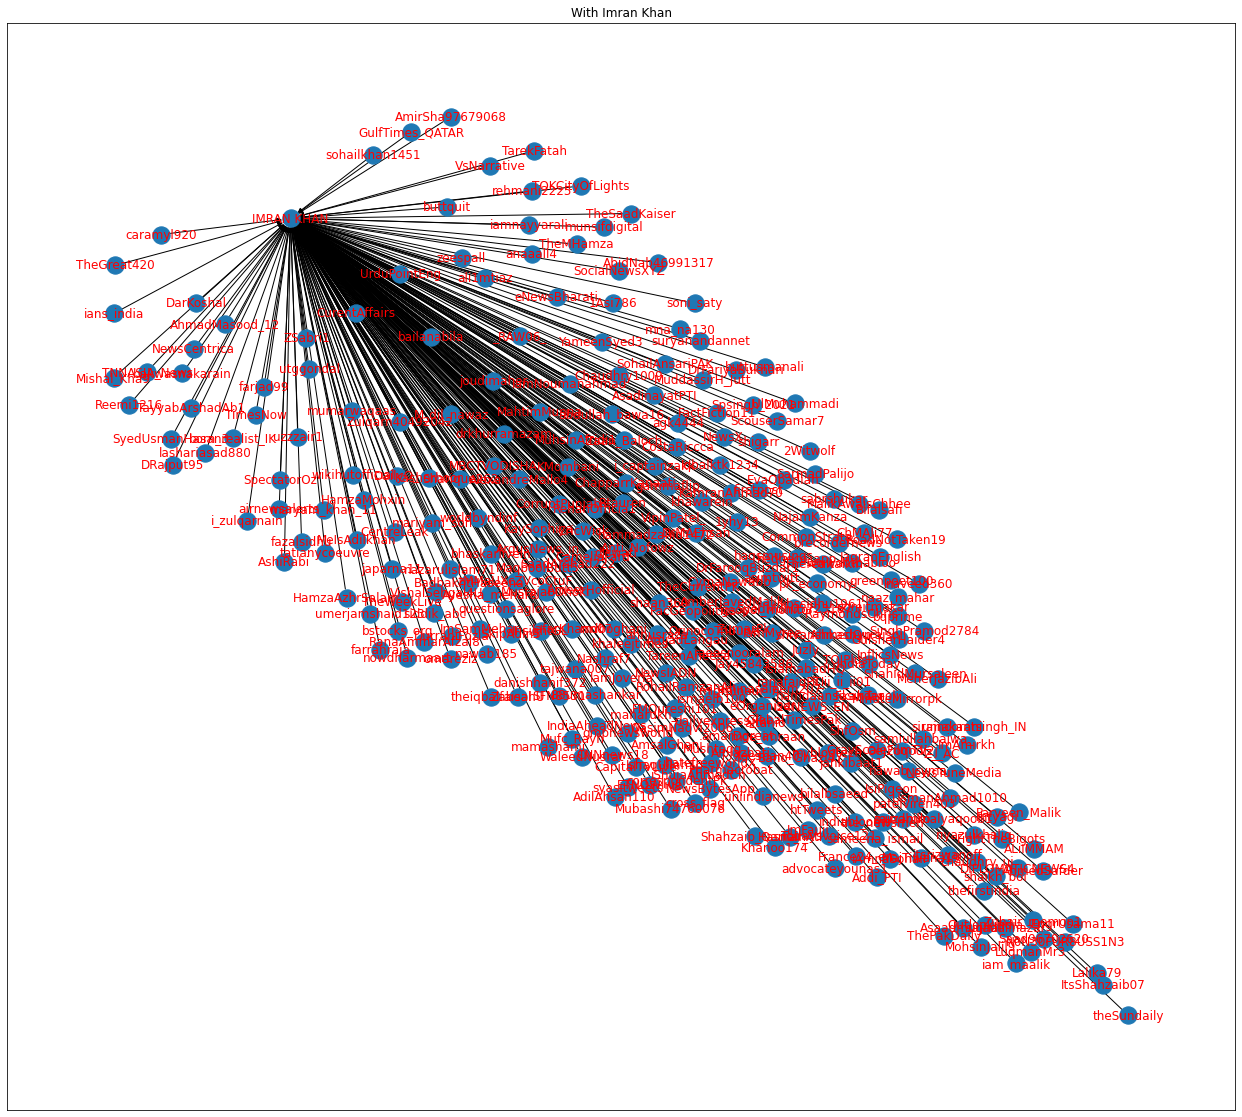

In [ ]:
subset = withImranKhan[['Users',"Politician"]]
tuples = [tuple(x) for x in subset.values]
G.add_edges_from(tuples)

print(G)
# illustrate graph
#Perform Graph Drawing
#A star network  (sort of)
plt.subplots(figsize=(22,20))
labels=dict(withImranKhan["Users"])
nx.draw_networkx(G,font_color="red")
plt.title("With Imran Khan")
plt.show()

Against Fuel Prices during imran Khan government

              Users                                              Tweet  \
2    tatianycoeuvre  pm imran khan who faces the prospect of being ...   
3      Bano_Ghazi47  pti still have the option of resigning from th...   
6          KMombani  maryamnsharif nawazsharifmns is a criminal a c...   
7          farjad99  planetnibiru safiwajahat imrankhanpti cmshehba...   
8    _AhmedQuraishi  chanting allah akbar lawmakers from outgoing p...   
..              ...                                                ...   
984     the_newsmen  the us has responded to pakistan prime ministe...   
985    JafarKhann07  khan saab finally pakistan free from cruel iro...   
990    khaleejtimes  pakistan the news of assassination plot comes ...   
992    NewsCentrica  pakistan prime minister imran khan has been hy...   
993    buttusmanali  breaking prime minister of pakistan pakpmo rec...   

      Opinion  Politician  
2    NEGATIVE  IMRAN KHAN  
3    NEGATIVE  IMRAN KHAN  
6    NEGATIVE  IMRAN KHAN  

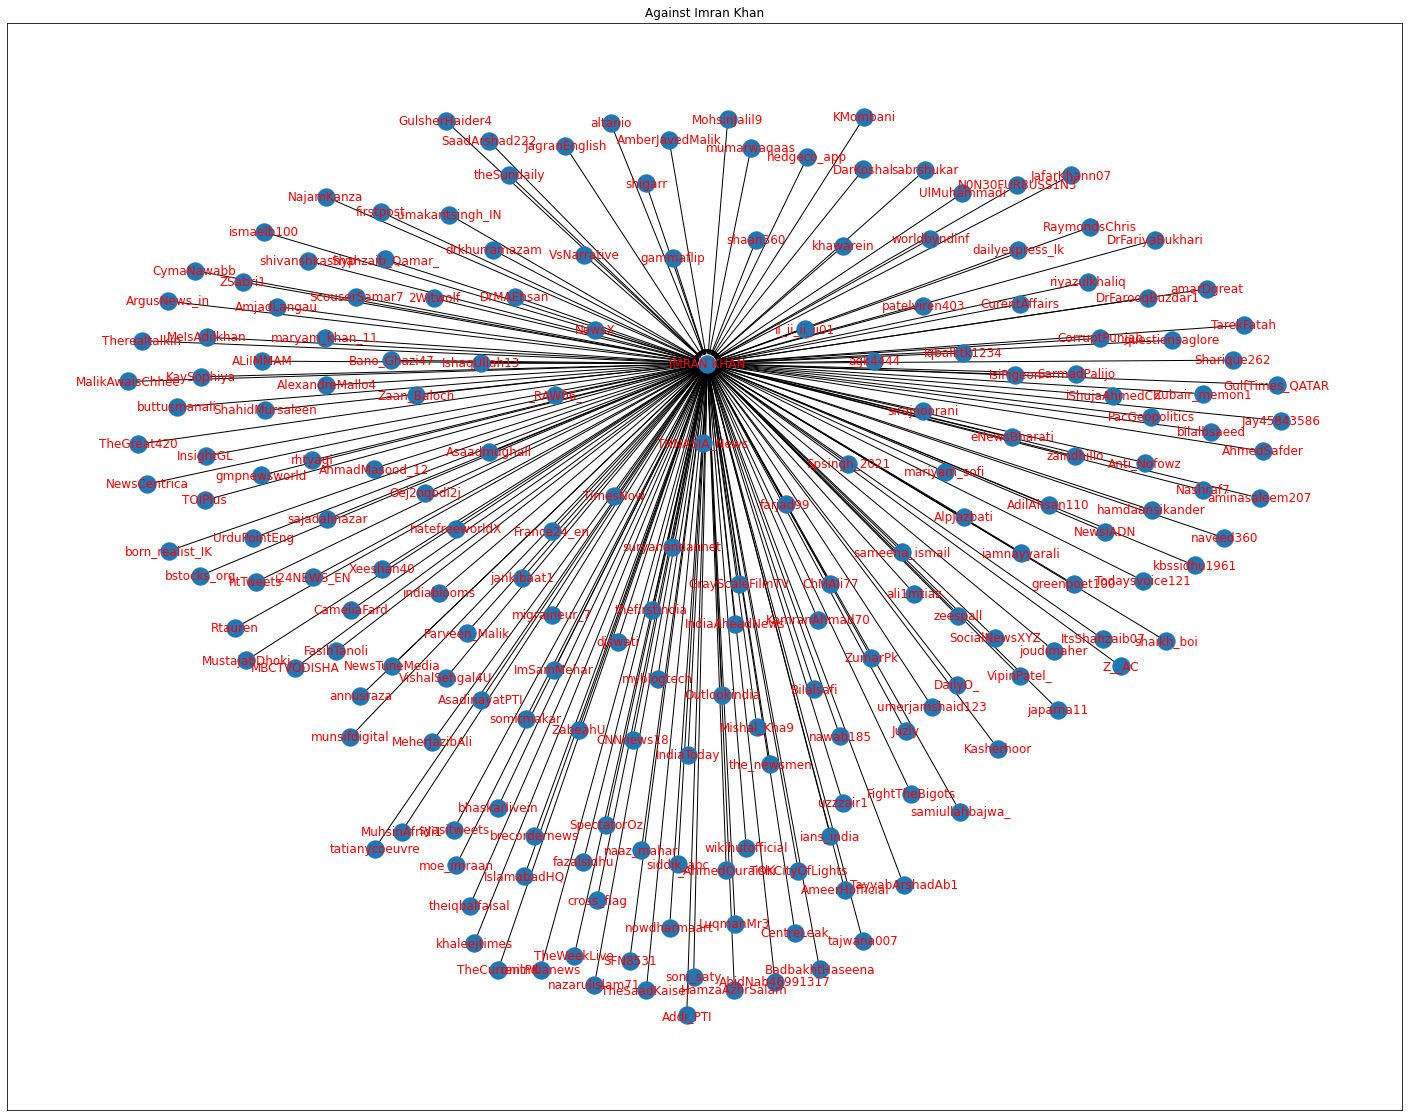

In [ ]:
df["Politician"]="IMRAN KHAN"
keywords = ["imran khan","pti","fuel"]
matches = df.loc[df.Tweet.apply(lambda x: any(k for k in keywords if k in x))][['Users','Tweet',"Opinion","Politician"]]
againstImranKhan=matches[matches.Opinion=="NEGATIVE"]
withImranKhan=matches[matches.Opinion=="POSITIVE"]
print(againstImranKhan)
# create object
G=nx.DiGraph()

#set layout
pos=nx.spring_layout(G)

df["Politician"]="IMRAN KHAN"
againstImranKhan
subset = againstImranKhan[['Users',"Politician"]]
tuples = [tuple(x) for x in subset.values]
G.add_edges_from(tuples)

print(G)

plt.subplots(figsize=(25,20))
nx.draw_networkx(G,font_color="red")
plt.title("Against Imran Khan")
plt.show()

DiGraph with 301 nodes and 300 edges


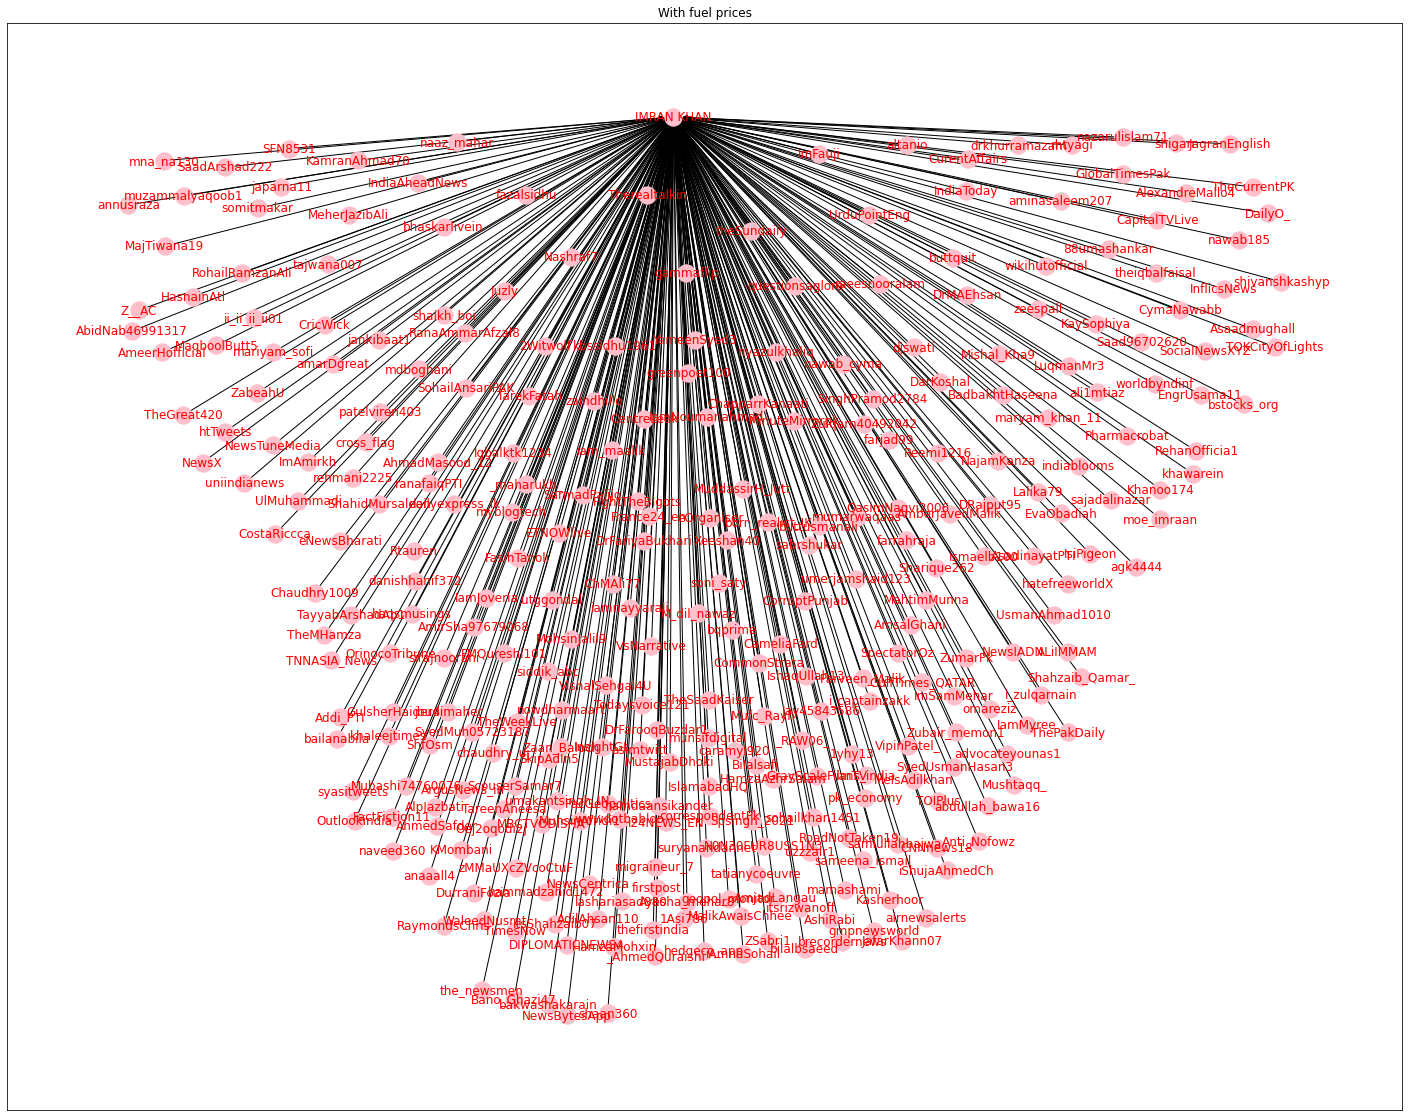

In [ ]:

df["Politician"]="IMRAN KHAN"
subset = withImranKhan[['Users',"Politician"]]
tuples = [tuple(x) for x in subset.values]
G.add_edges_from(tuples)

print(G)

plt.subplots(figsize=(25,20))
nx.draw_networkx(G,font_color="red",node_color = 'pink')
plt.title("With fuel prices")
plt.show()

**Sentiment Density Score**

In [ ]:
print("Density Score")
print(len(againstImranKhan)/len(matches))
print(len(withImranKhan)/len(matches))

list1= ['ImranKhan',"pti",]
# check the pandas subjects column
# contain the given list of strings
hastags=list(df['Hastags'])
Users=list(df['Users'])
tweets=list(df['Tweet'])
Opinion=list(df['Opinion'])
keywords=['ImranKhan']
users=[]

for i,j,k in zip(hastags,Users,tweets):
   len(list(i))
   if (keywords[0] in i) and len(list(i))<56:
      users.append(j)

print(len(users))

Density Score
0.653179190751445
0.3468208092485549
663


Density Scoere

In [ ]:
print("Density Score")
print(len(againstImranKhan)/len(matches))
print(len(withImranKhan)/len(matches))

list1= ['ImranKhan',"pti"]
# check the pandas subjects column
# contain the given list of strings
hastags=list(df['Hastags'])
Users=list(df['Users'])
tweets=list(df['Tweet'])
Opinion=list(df['Opinion'])
keywords=['ImranKhan',"PmKhan","PTI","NayaPakistan"]
users=[]
opi=[]
for i,j,k,l in zip(hastags,Users,tweets,Opinion):
   len(list(i))
   if ((keywords[0] in i) or (keywords[2] in i) or (keywords[1] in i)) and (len(list(i))<45):
         users.append(j)
         print(i)
         opi.append(l)

print(len(matches))

Density Score
0.653179190751445
0.3468208092485549
['ImranKhan']
['ImranKhan']
['ImranKhan']
['ImranKhan']
['PTI', 'ImranKhan']
['ImranKhan', 'ISFswat']
['ImranKhan', 'PunjabAssembly']
['ImranKhan', 'ImranKhan']
['PTIGovernment', 'ImranKhan']
['Pakistan', 'ImranKhan']
['MiddayNews', 'ImranKhan']
['ImranKhan', 'HangTheTraitors']
['opposition', 'ImranKhan', 'Elections2022']
['ImranKhan']
['ImranKhan', 'RulersNotLeaders']
['ImranKhan', 'SavePakistan']
['SupremeCourt', 'ImranKhan']
['PakArmy', 'ImranKhan', 'SavePakistan']
['ImranKhan', 'US']
['ImranKhan']
['ImranKhan', 'Pakistan', 'PTI']
['BehindYouSkipper', 'ImranKhan']
['ImranKhan', 'بھگوڑا']
['ImranKhan', 'Pakistan', 'US', 'ImranKhan']
['Pakistan', 'ImranKhan']
['NewsPMC', 'ImranKhan', 'ArifAlvi']
['ImranKhan']
['ImranKhan', 'Gulf', 'socialnewsxyz']
['ImranKhan', 'Gulf', 'socialnewsxyz']
['ImranKhan', 'Pakistan']
['ImranKhan', 'PunjabAssembly', 'Pakistan']
['ImranKhan', 'PakistanArmy']
['SupremeCourtofpakistan', 'ImranKhan']
['ImranKhan